In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xbg

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
# separate main drum components
files_snare = glob('data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike/*.wav')
files_toms = glob('data/MDLib2.2/MDLib2.2/Sorted/Rack Tom/Strike/*.wav')
files_toms_floor = glob('data/MDLib2.2/MDLib2.2/Sorted/Floor Tom/Strike/*.wav')
files_kick = glob('data/MDLib2.2/MDLib2.2/Sorted/Kick/*/*/*.wav')
files_cymbals = glob('data/MDLib2.2/MDLib2.2/Sorted/Cymbals/*/*/*.wav')

# combine tom files
for i in files_toms_floor:
    files_toms.append(i)

#audio_files = glob('data/MDLib2.2/MDLib2.2/Sorted/*/*/*.wav')

In [3]:
# def load_file_list(file_list):
#     for file in file_list:
#         y, sr = librosa.load(file)
        
#     return y, sr

In [4]:
#load_file_list(files_snare)

(array([ 3.8010576e-06, -1.4757405e-05, -1.2786139e-05, ...,
        -8.2395979e-07,  5.5941621e-07, -3.4422567e-06], dtype=float32),
 22050)

In [5]:
def load_file(file):
    
    y_values = []
    sample_rates = []
    
    for i in file:
        
        y, sr = librosa.load(i)
        
        y_values.append(y)
        sample_rates.append(sr)
        
        
        
    return y_values, sample_rates

In [6]:
#load_file(files_snare)

In [10]:
# duration of file
def get_duration(file):
    dur = librosa.get_duration(filename=file)
    return dur

In [11]:
def trim_audio(y, db=25):
    y_trimmed, ind = librosa.effects.trim(y, top_db=db)
    dur_trimmed = librosa.get_duration(y=y_trimmed)
    return(dur_trimmed)

In [12]:
def trim_y(y, db=25):
    y_trimmed, ind = librosa.effects.trim(y, top_db=db)
    return(y_trimmed)

### Dataframe Assembly

#### Assembly Cont.
    Snare Dataframe Assembly

In [13]:
files_snare[:5]

['data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\\DI_Snare_Strike_1111.1.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\\DI_Snare_Strike_1111.2.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\\DI_Snare_Strike_1111.3.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\\DI_Snare_Strike_1111.4.wav',
 'data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\\DI_Snare_Strike_1112.1.wav']

In [14]:
y, sr = load_file(files_snare)

snare = pd.DataFrame({
    "file_name": files_snare,
    "ins": 'snare',
    "sr": sr,
    "y": y
})

In [15]:
snare['y_trimmed'] = snare['y'].map(trim_y)
snare['length'] = snare['file_name'].map(get_duration)
snare['length_trimmed'] = snare['y'].map(trim_audio)
snare.head()

,file_name,ins,sr,y,y_trimmed,length,length_trimmed
0,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-1.5206266e-05, -1.3785218e-05, -8.188464e-06...","[-1.5206266e-05, -1.3785218e-05, -8.188464e-06...",0.932336,0.255420
1,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-2.0711204e-05, -1.7712298e-05, -9.776115e-06...","[-2.0711204e-05, -1.7712298e-05, -9.776115e-06...",0.640068,0.278639
2,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-7.5879116e-06, 2.1694016e-06, 1.2658389e-05,...","[-7.5879116e-06, 2.1694016e-06, 1.2658389e-05,...",0.792449,0.255420
3,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[1.1276075e-05, 7.2365297e-06, 2.8594923e-06, ...","[1.1276075e-05, 7.2365297e-06, 2.8594923e-06, ...",0.705147,0.255420
4,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[3.2032644e-05, 3.0818876e-05, -5.6142153e-06,...","[3.2032644e-05, 3.0818876e-05, -5.6142153e-06,...",0.887007,0.208980


#### Preview First Snare Sound With iPython

In [16]:
ipd.Audio(snare['file_name'].iloc[0])

#### Checking Difference in Length After Trimming

In [17]:
librosa.get_duration(y=snare['y'].iloc[0], sr=22050)
#0.9323356009070295

0.9323356009070295

In [18]:
x, ind = librosa.effects.trim(y=snare['y'].iloc[0], top_db=25)
librosa.get_duration(y=x)
#0.25541950113378686

0.25541950113378686

#### Assembly Cont.
    Remaining Dataframe Assembly

In [19]:
# Create TOMS dataframe
y, sr = load_file(files_toms)

toms = pd.DataFrame({
    "file_name": files_toms,
    "ins": 'tom',
    "sr": sr,
    "y": y
})

# Add trimmed columns
toms['y_trimmed'] = toms['y'].map(trim_y)
toms['length'] = toms['file_name'].map(get_duration)
toms['length_trimmed'] = toms['y'].map(trim_audio)

# ---------------------
# Create KICK dataframe
y, sr = load_file(files_kick)

kick = pd.DataFrame({
    "file_name": files_kick,
    "ins": 'kick',
    "sr": sr,
    "y": y
})

# Add trimmed columns
kick['y_trimmed'] = kick['y'].map(trim_y)
kick['length'] = kick['file_name'].map(get_duration)
kick['length_trimmed'] = kick['y'].map(trim_audio)

# ---------------------
# Create CYMBALS dataframe
y, sr = load_file(files_cymbals)

cymbals = pd.DataFrame({
    "file_name": files_cymbals,
    "ins": 'cymbal',
    "sr": sr,
    "y": y
})

# Add trimmed columns
cymbals['y_trimmed'] = cymbals['y'].map(trim_y)
cymbals['length'] = cymbals['file_name'].map(get_duration)
cymbals['length_trimmed'] = cymbals['y'].map(trim_audio)

# ---------------------
# COMBINE dataframes
df_list = [snare, toms, kick, cymbals]

df = pd.concat(df_list)

In [39]:
df.head(5)

,file_name,ins,sr,y,y_trimmed,length,length_trimmed
0,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-1.5206266e-05, -1.3785218e-05, -8.188464e-06...","[-1.5206266e-05, -1.3785218e-05, -8.188464e-06...",0.932336,0.255420
1,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-2.0711204e-05, -1.7712298e-05, -9.776115e-06...","[-2.0711204e-05, -1.7712298e-05, -9.776115e-06...",0.640068,0.278639
2,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-7.5879116e-06, 2.1694016e-06, 1.2658389e-05,...","[-7.5879116e-06, 2.1694016e-06, 1.2658389e-05,...",0.792449,0.255420
3,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[1.1276075e-05, 7.2365297e-06, 2.8594923e-06, ...","[1.1276075e-05, 7.2365297e-06, 2.8594923e-06, ...",0.705147,0.255420
4,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[3.2032644e-05, 3.0818876e-05, -5.6142153e-06,...","[3.2032644e-05, 3.0818876e-05, -5.6142153e-06,...",0.887007,0.208980


## Feature Engineering

In [112]:
def get_summary_stats(y):
    
    # creates one column df to perform descriptive stats on
    col = pd.DataFrame(y).T
    
    # get descriptive stats
    ds = col.describe(include='all')
    
    # assign variables for each stat
    mean = ds.loc['mean']
    std = ds.loc['std']
    mini = ds.loc['min']
    q1 = ds.loc['25%']
    medi = ds.loc['50%']
    q3 = ds.loc['75%']
    maxi = ds.loc['max']
    
    return(mean, std, mini, q1, medi, q3, maxi)

In [54]:
def calc_rms(y):
    rms = librosa.feature.rms(y=y, frame_length=2048)
    return(rms)

In [149]:
def calc_rms_summary(y):
    rms = librosa.feature.rms(y=y, frame_length=2048)
    
    results = get_summary_stats(rms)
    return(rms, results)

In [155]:
x = calc_rms_summary(df['y_trimmed'].iloc[-1])
# index [0] = rms
# index [1] = summary stats
# index [1][6] = max val within summary
x[1][6]

0    0.00901
Name: max, dtype: float64

In [60]:
def calc_spec_centroid(y):
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=22050)
    return(spec_cent)

In [62]:
def calc_spec_bandwidth(y):
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=22050)
    return(spec_bandwidth)

In [63]:
def calc_spec_rolloff(y):
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=22050)
    return(spec_rolloff)

In [64]:
def calc_zero_cross(y):
    zero_cross_rate = librosa.feature.zero_crossing_rate(y=y, frame_length=2048)
    return(zero_cross_rate)

In [65]:
# df['rms'] = df['y_trimmed'].map(calc_rms)
# df['spec_centroid'] = df['y_trimmed'].map(calc_spec_centroid)
# df['spec_bandwidth'] = df['y_trimmed'].map(calc_spec_bandwidth)
# df['spec_rolloff'] = df['y_trimmed'].map(calc_spec_rolloff)
# df['zero_cross_rate'] = df['y_trimmed'].map(calc_zero_cross)
# df.head()

,file_name,ins,sr,y,y_trimmed,length,length_trimmed,rms,spec_centroid,spec_bandwidth,spec_rolloff,zero_cross_rate
0,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-1.5206266e-05, -1.3785218e-05, -8.188464e-06...","[-1.5206266e-05, -1.3785218e-05, -8.188464e-06...",0.932336,0.255420,"[[0.004205495, 0.004348958, 0.0044075986, 0.00...","[[2200.5189792513956, 3002.457212659452, 3718....","[[2723.8404070947267, 2942.132238742537, 2902....","[[5695.5322265625, 6599.9267578125, 7149.02343...","[[0.060546875, 0.10595703125, 0.12939453125, 0..."
1,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-2.0711204e-05, -1.7712298e-05, -9.776115e-06...","[-2.0711204e-05, -1.7712298e-05, -9.776115e-06...",0.640068,0.278639,"[[0.0032281945, 0.0033489498, 0.003410472, 0.0...","[[1803.2787502736414, 2625.3336033881524, 3486...","[[2418.1488449401686, 2818.180807943793, 2943....","[[4694.23828125, 6201.5625, 7084.423828125, 70...","[[0.05078125, 0.09716796875, 0.11181640625, 0...."
2,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[-7.5879116e-06, 2.1694016e-06, 1.2658389e-05,...","[-7.5879116e-06, 2.1694016e-06, 1.2658389e-05,...",0.792449,0.255420,"[[0.00508139, 0.005222573, 0.005277782, 0.0029...","[[2391.734179798895, 3130.3006695626864, 3872....","[[2718.6433974826887, 2899.808415792062, 2886....","[[5824.7314453125, 6707.5927734375, 7149.02343...","[[0.0869140625, 0.138671875, 0.17138671875, 0...."
3,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[1.1276075e-05, 7.2365297e-06, 2.8594923e-06, ...","[1.1276075e-05, 7.2365297e-06, 2.8594923e-06, ...",0.705147,0.255420,"[[0.004907273, 0.0050597284, 0.005114825, 0.00...","[[2328.0298045347536, 3085.019419097238, 3766....","[[2732.3322825480905, 2920.262525288708, 2892....","[[5867.7978515625, 6524.560546875, 7127.490234...","[[0.06884765625, 0.111328125, 0.146484375, 0.1..."
4,data/MDLib2.2/MDLib2.2/Sorted/Snare/Strike\DI_...,snare,22050,"[3.2032644e-05, 3.0818876e-05, -5.6142153e-06,...","[3.2032644e-05, 3.0818876e-05, -5.6142153e-06,...",0.887007,0.208980,"[[0.011127708, 0.011215802, 0.011251543, 0.003...","[[2348.4221846543037, 3005.264667800001, 3995....","[[2671.496250529427, 2854.480228129577, 2842.8...","[[5652.4658203125, 6449.1943359375, 7256.68945...","[[0.11962890625, 0.18212890625, 0.21923828125,..."


In [ ]:
# # calc root mean square value for each frame of audio sample
# librosa.feature.rms(y=y, frame_length=2048)

# # how low or how high sound is - takes avg of pitch
# librosa.feature.spectral_centroid(y=y, sr=sr)

# # band-width at one half peak maximum energy
# librosa.feature.spectral_bandwidth(y=y, sr=sr)

# # measures frequency at which some percentage
# # (usually 85%) of total energy is contained
# librosa.feature.spectral_rolloff(y=y, sr=sr)

# # compute zero crossing rate of an audio time series
# # default frame length is 2048
# librosa.feature.zero_crossing_rate(y=y, frame_length=2048)

In [111]:
q = calc_rms(y=df['y_trimmed'].iloc[-1])
w = pd.DataFrame(q).T.describe()
print(w.index)
w

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')


,0
count,49.000000
mean,0.001821
std,0.002064
min,0.000358
25%,0.000673
50%,0.001040
75%,0.001865
max,0.009010


In [110]:
q = calc_rms(y=df['y_trimmed'].iloc[-1])


w = pd.DataFrame(q).T
e = w.describe(include='all')
e.loc['mean']

0    0.001821
Name: mean, dtype: float64

In [79]:
librosa.feature.rms(y=df['y_trimmed'].iloc[-1], frame_length=2048)

array([[0.00847288, 0.00877546, 0.00900975, 0.005722  , 0.0039566 ,
        0.00357084, 0.00316341, 0.00273341, 0.00251583, 0.00227991,
        0.00217219, 0.0020466 , 0.00186498, 0.00166695, 0.00153854,
        0.00148877, 0.00145649, 0.00145264, 0.00139286, 0.00131768,
        0.00124905, 0.0011682 , 0.00114778, 0.00109853, 0.00103968,
        0.00102503, 0.00097659, 0.00094363, 0.00090763, 0.00087124,
        0.00084407, 0.00081066, 0.00079823, 0.00075599, 0.00071479,
        0.00069475, 0.00066649, 0.00067272, 0.000673  , 0.00067145,
        0.00064727, 0.00062557, 0.00059566, 0.00058079, 0.00056562,
        0.00054515, 0.00052515, 0.00043725, 0.00035774]], dtype=float32)

In [140]:
q = calc_rms(y=df['y_trimmed'].iloc[-1])


x = get_summary_stats(q)
x

(0    0.001821
 Name: mean, dtype: float64,
 0    0.002064
 Name: std, dtype: float64,
 0    0.000358
 Name: min, dtype: float64,
 0    0.000673
 Name: 25%, dtype: float64,
 0    0.00104
 Name: 50%, dtype: float64,
 0    0.001865
 Name: 75%, dtype: float64,
 0    0.00901
 Name: max, dtype: float64)

## ML Testing

In [66]:
inp = df.drop(columns=['ins', 'file_name', 'sr', 'y', 'y_trimmed'])
target = df['ins']

In [67]:
inp.head(3)

,length,length_trimmed,rms,spec_centroid,spec_bandwidth,spec_rolloff,zero_cross_rate
0,0.932336,0.255420,"[[0.004205495, 0.004348958, 0.0044075986, 0.00...","[[2200.5189792513956, 3002.457212659452, 3718....","[[2723.8404070947267, 2942.132238742537, 2902....","[[5695.5322265625, 6599.9267578125, 7149.02343...","[[0.060546875, 0.10595703125, 0.12939453125, 0..."
1,0.640068,0.278639,"[[0.0032281945, 0.0033489498, 0.003410472, 0.0...","[[1803.2787502736414, 2625.3336033881524, 3486...","[[2418.1488449401686, 2818.180807943793, 2943....","[[4694.23828125, 6201.5625, 7084.423828125, 70...","[[0.05078125, 0.09716796875, 0.11181640625, 0...."
2,0.792449,0.255420,"[[0.00508139, 0.005222573, 0.005277782, 0.0029...","[[2391.734179798895, 3130.3006695626864, 3872....","[[2718.6433974826887, 2899.808415792062, 2886....","[[5824.7314453125, 6707.5927734375, 7149.02343...","[[0.0869140625, 0.138671875, 0.17138671875, 0...."


In [68]:
X_train, X_test, y_train, y_test = train_test_split(inp, target, random_state=42)

In [69]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)

rf.fit(X_train, y_train)

ValueError: setting an array element with a sequence.

In [41]:
results = rf.predict(X_test)

In [49]:
results

array(['cymbal', 'cymbal', 'snare', 'cymbal', 'cymbal', 'cymbal', 'kick',
       'snare', 'snare', 'tom', 'cymbal', 'cymbal', 'tom', 'kick',
       'cymbal', 'cymbal', 'tom', 'snare', 'tom', 'cymbal', 'kick',
       'kick', 'cymbal', 'kick', 'cymbal', 'cymbal', 'cymbal', 'cymbal',
       'cymbal', 'tom', 'cymbal', 'tom', 'cymbal', 'cymbal', 'cymbal',
       'snare', 'tom', 'cymbal', 'cymbal', 'tom', 'cymbal', 'cymbal',
       'cymbal', 'snare', 'cymbal', 'cymbal', 'cymbal', 'snare', 'snare',
       'cymbal', 'tom', 'cymbal', 'snare', 'kick', 'snare', 'tom',
       'cymbal', 'kick', 'cymbal', 'cymbal', 'cymbal', 'tom', 'kick',
       'cymbal', 'cymbal', 'kick', 'cymbal', 'tom', 'cymbal', 'snare',
       'tom', 'cymbal', 'cymbal', 'snare', 'tom', 'cymbal', 'cymbal',
       'kick', 'snare', 'kick', 'cymbal', 'snare', 'kick', 'tom',
       'cymbal', 'tom', 'cymbal', 'kick', 'cymbal', 'cymbal', 'kick',
       'cymbal', 'cymbal', 'tom', 'cymbal', 'cymbal', 'tom', 'cymbal',
       'kick', 'sn

In [43]:
print(classification_report(y_test, results))

              precision    recall  f1-score   support

      cymbal       0.88      0.93      0.90       514
        kick       0.89      0.85      0.87       128
       snare       0.88      0.78      0.82       169
         tom       0.86      0.85      0.86       189

    accuracy                           0.88      1000
   macro avg       0.88      0.85      0.86      1000
weighted avg       0.88      0.88      0.88      1000



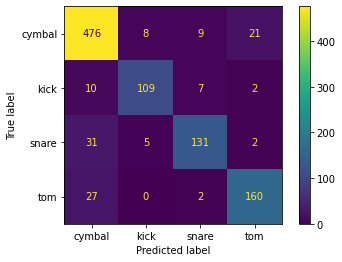

In [52]:
# Create confusion matrix
cm = confusion_matrix(y_test, results)

# display confusion matrix with ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
cm_display.plot();

# Plot

### Trimming

In [19]:
# ipython display audio method - used on last cymbal sound in library
ipd.Audio(df['file_name'].iloc[-1])

In [20]:
y, sr = librosa.load(df['file_name'].iloc[-1])
# print(f'y: {y[:10]}')
# print(f'shape y: {y.shape}')
# print(f'sr: {sr}')

#--output--
#y: [-1.5206266e-05 -1.3785218e-05 -8.1884637e-06  1.2335660e-06
 #-1.5576163e-05 -1.8971021e-05  1.1400133e-05 -7.5695393e-06
 #-2.3335941e-05 -1.7152441e-05]
#shape y: (20558,)
#sr: 22050

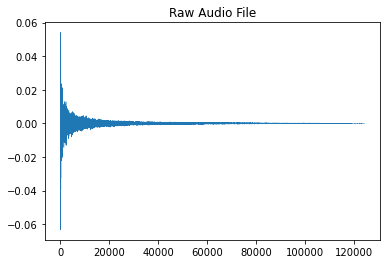

In [21]:
pd.Series(y).plot(lw=0.5, 
                  title='Raw Audio File');

trim low end db off and provide index?..

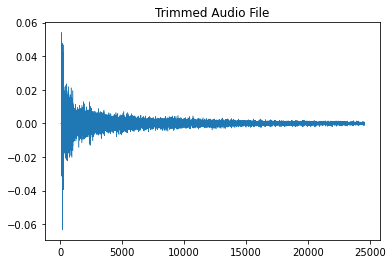

In [32]:
y_trimmed, ind = librosa.effects.trim(y, top_db=25)

pd.Series(y_trimmed).plot(lw=0.5, 
                          title='Trimmed Audio File');

In [23]:
ipd.Audio(y_trimmed, rate=22050)

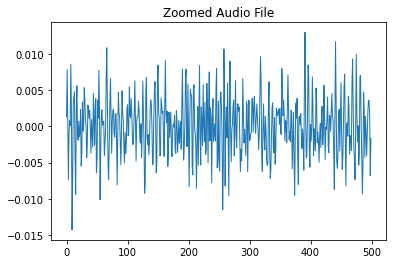

In [24]:
y_zoomed = y[1500:2000]

pd.Series(y_zoomed).plot(lw=1, 
                  title='Zoomed Audio File');

## Spectogram

stft (Short-time Fourier transform)

    Signature:
    librosa.stft(
        y,
        *,
        n_fft=2048,
        hop_length=None,
        win_length=None,
        window='hann',
        center=True,
        dtype=None,
        pad_mode='constant',
    )

In [25]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 243)

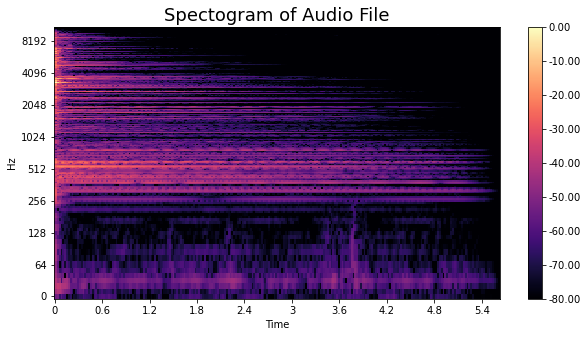

In [26]:
# plot transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title("Spectogram of Audio File", fontsize=18)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

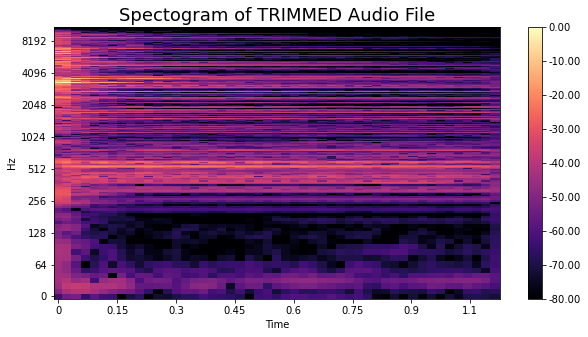

In [31]:
# plot transformed TRIMMED audio data

D = librosa.stft(y_trimmed)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape


fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title("Spectogram of TRIMMED Audio File", fontsize=18)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

## Mel Spectogram

In [27]:
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)

S_db_mel = librosa.amplitude_to_db(np.abs(S), ref=np.max)

<ipython-input-27-e726c4d32c18>:1: FutureWarning: Pass y=[ 2.4011670e-05  2.2022523e-06 -1.7754817e-06 ... -4.6459973e-06
 -5.3888925e-07 -4.6670298e-06] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)


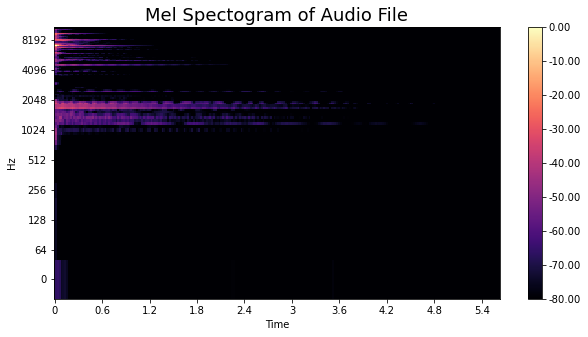

In [28]:
# plot transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title("Mel Spectogram of Audio File", fontsize=18)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In [29]:
S_db_mel

array([[-74.33144 , -66.05196 , -65.54496 , ..., -80.      , -80.      ,
        -80.      ],
       [-73.040344, -75.30981 , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-70.93929 , -72.53845 , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       ...,
       [-76.62992 , -78.38188 , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)